In [11]:
import pandas as pd
import numpy as np
import talib as ta

import seaborn as sns
import matplotlib.pyplot as plt


PATH_READ = 'result_Close_1min.csv'


df = pd.read_csv(PATH_READ)

# df = df[['Target_Class_Avg_1min', 'prediction_label']]

print(df.columns)

Index(['Timestamp', 'tta_STDDEV_timeperiod_9', 'tta_NATR_timeperiod_28',
       'tta_ADOSC_fastperiod_5_slowperiod_20', 'tta_MINUS_DM_timeperiod_7',
       'tta_ADX_timeperiod_11',
       'tta_ULTOSC_timeperiod1_37_timeperiod2_38_timeperiod3_25',
       'tta_HT_PHASOR_0', 'tta_HT_PHASOR_1', 'tta_MFI_timeperiod_35',
       ...
       'STOCK_tta_CDLMATCHINGLOW', 'STOCK_tta_CDLHANGINGMAN',
       'STOCK_tta_CDL3OUTSIDE', 'STOCK_tta_CDLSTALLEDPATTERN',
       'STOCK_tta_CDLHARAMICROSS', 'STOCK_tta_CDL3INSIDE',
       'STOCK_tta_CDLSEPARATINGLINES', 'STOCK_tta_CDLHOMINGPIGEON',
       'Target_Close_1min', 'prediction_label'],
      dtype='object', length=146)


In [12]:
min_value = df['prediction_label'].min()
max_value = df['prediction_label'].max()

print('Predict min: ' + str(min_value))
print('Predict max: ' + str(max_value))

Predict min: -0.0152481279613803
Predict max: 0.0256206784354776


<Axes: >

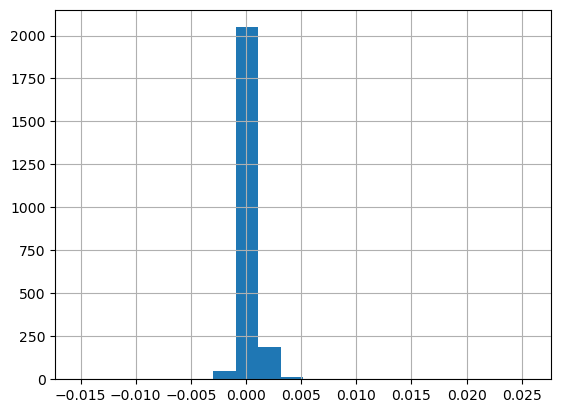

In [13]:
df['prediction_label'].hist(bins=20)


In [14]:
def quantiles(df, num_interval):
    df_sorted = df.sort_values(by='prediction_label')
    df_sorted = df_sorted.dropna(subset=['prediction_label'])
   
    quantile_markers = pd.qcut(df_sorted['prediction_label'],q=num_interval, labels=False)

# Add the quantile markers as a new column to the DataFrame
    df_sorted['Interval_Marker'] = quantile_markers

    return df_sorted

In [15]:
df_sorted = quantiles(df, 10)

In [29]:
def quant_analysis_list(df, num_interval, target):
    results = []

    for i in range(num_interval):
        selected_rows = df[df['Interval_Marker'] == i]

        acc = (selected_rows[target] * selected_rows['prediction_label'] > 0).mean() * 100
        p_corr = selected_rows[target].corr(selected_rows['prediction_label'])
        s_corr = selected_rows[target].corr(selected_rows['prediction_label'], method='spearman')
        true_mean = selected_rows[target].mean()
        pred_mean = selected_rows['prediction_label'].mean()

        results.append([i, acc, p_corr, s_corr, true_mean, pred_mean])

    # Create the summary DataFrame
    columns = ['Interval', 'Percent in the Same Direction', 'Correlation Pearson', 'Correlation Spearman', 'True Mean', 'Predicted Mean']
    summary_df = pd.DataFrame(results, columns=columns)

    summary_df.index = summary_df['Interval']
    summary_df.drop(columns='Interval', inplace=True)

    return summary_df

In [17]:
def see_interval(df, interval, target):
    plt.figure(figsize=(10, 5))

    interval_counts = []
    interval_labels = [] 

    for index in interval:
        selected_rows = df[df['Interval_Marker'] == index]

        selected_rows = selected_rows.reset_index()
        text = 'Interval ' + str(index)
        sns.lineplot(data=selected_rows[target], label= text, alpha=0.5)

        # sns.histplot(data=selected_rows[target], kde=True, label = text)
       
    plt.show()

In [18]:
def count_interval(df, interval, target, truthValues):
    plt.figure(figsize=(10, 5))

    interval_counts = []
    interval_labels = [] 

    for index in interval:
        selected_rows = df[(df['Interval_Marker'] == index) & (df[target].isin(truthValues))]

        selected_rows = selected_rows.reset_index()
        text = 'Interval ' + str(index)
        
        count = selected_rows[target].count()
        interval_counts.append(count)
        interval_labels.append('Interval ' + str(index))

    sns.barplot(x=interval_labels, y=interval_counts)
    plt.show()

In [27]:
def categorical_pred_distribution(df, interval, target, truthValues, future_minutes):
    # df['Timestamp'] = df.index
    # df.reset_index(drop= True, inplace=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df_time_sort = df.sort_values(by='Timestamp')
    

    for interval_index in interval:
        selected_rows = df_time_sort[(df_time_sort['Interval_Marker'] == interval_index) & ((df_time_sort[target].isin(truthValues)))]
        print("Signal appeared " + str(selected_rows.shape[0]) + " Times in interval " + str(interval_index))

        result = []
        for index, row in selected_rows.iterrows():
            future_index = index + future_minutes
    
            if future_index < len(df):
                future_scores = df.loc[future_minutes+1:future_index, 'Target_Close_1min']
                future_average = future_scores.mean()

                result.append(future_average)

            else:
                print(f"Row {index}: Not enough future rows for average calculation")    
        
        text = 'Interval ' + str(interval_index)
        sns.lineplot(data=result, label= text, alpha=0.5)
    
    plt.title(target)
    plt.show() 

In [20]:
def categorical_pred_FULL(df, target, truthValues, future_minutes):
    # df.reset_index(drop= True, inplace=True)
    # df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df_time_sort = df.sort_values(by='Timestamp')
    
    # print(df_time_sort)

    selected_rows = df_time_sort[(df_time_sort[target].isin(truthValues))]
    print("Signal appeared " + str(selected_rows.shape[0]) + " Times in total.")

    result = []
    for index, row in selected_rows.iterrows():
        future_index = index + future_minutes

        if future_index < len(df):
            future_scores = df.loc[future_minutes+1:future_index, 'Target_Close_1min']
            future_average = future_scores.mean()

            result.append(future_average)

        else:
            print(f"Row {index}: Not enough future rows for average calculation")    

    sns.lineplot(data=result, label= target, alpha=0.5)

    plt.title(target)
    plt.show() 

In [30]:
print(quant_analysis_list(df_sorted, 10, 'Target_Close_1min'))

          Percent in the Same Direction  Correlation Pearson  \
Interval                                                       
0                             62.500000             0.069171   
1                             58.008658             0.010045   
2                             53.448276             0.022817   
3                             45.887446             0.052610   
4                             45.258621            -0.017115   
5                             46.320346             0.017161   
6                             53.679654             0.087570   
7                             43.965517            -0.005671   
8                             53.679654             0.087585   
9                             49.568966             0.134424   

          Correlation Spearman  True Mean  Predicted Mean  
Interval                                                   
0                     0.134164  -0.000304       -0.000866  
1                     0.017127  -0.000053       -0.

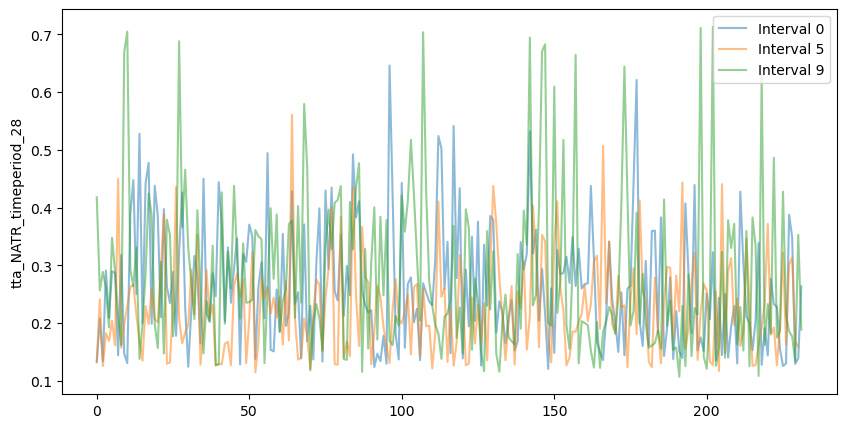

In [33]:
see_interval(df_sorted,[0,5,9], 'tta_NATR_timeperiod_28')

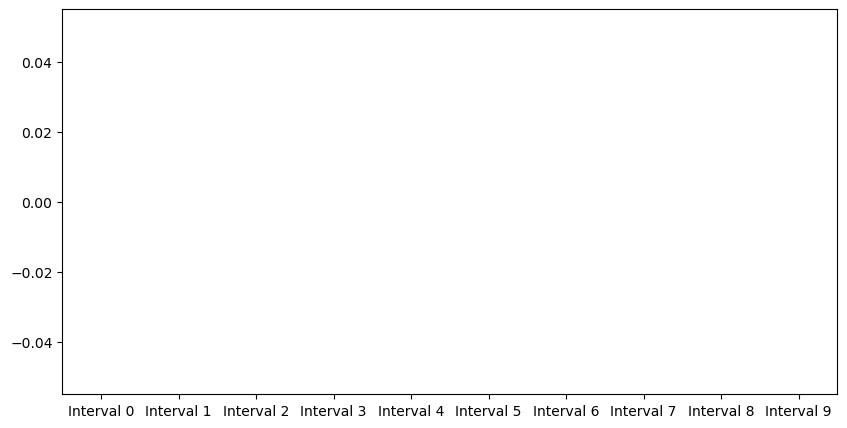

In [26]:
count_interval(df_sorted,np.arange(10),'tta_CDLCLOSINGMARUBOZU', [-100,100])

Signal appeared 45 Times in interval 1


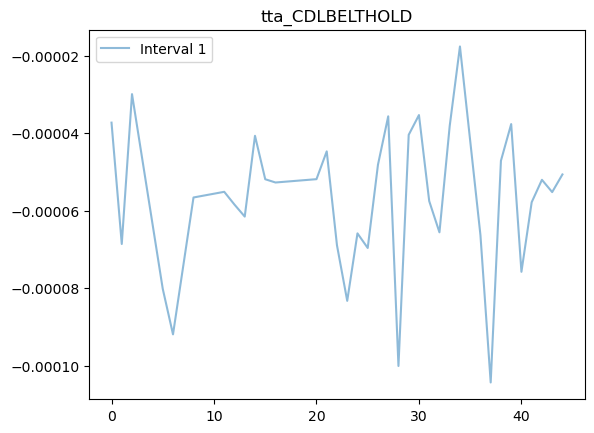

In [28]:
categorical_pred_distribution(df_sorted,[1],'tta_CDLBELTHOLD',[-100,100],5)

Signal appeared 460 Times in total.


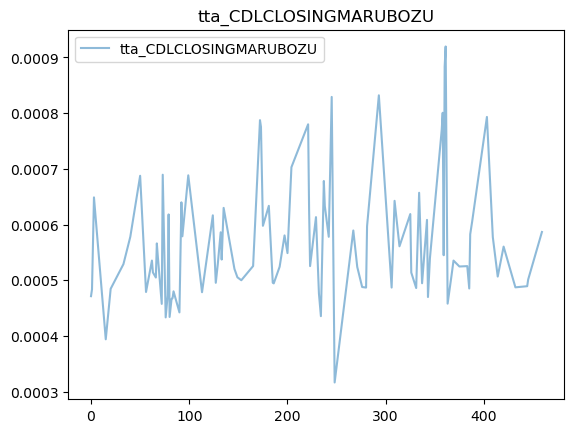

In [ ]:
categorical_pred_FULL(df_sorted,'tta_CDLCLOSINGMARUBOZU', [100,-100], 1)

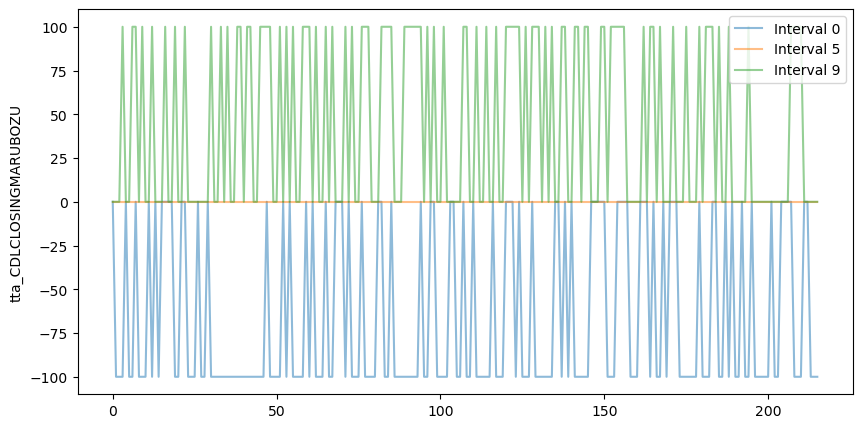

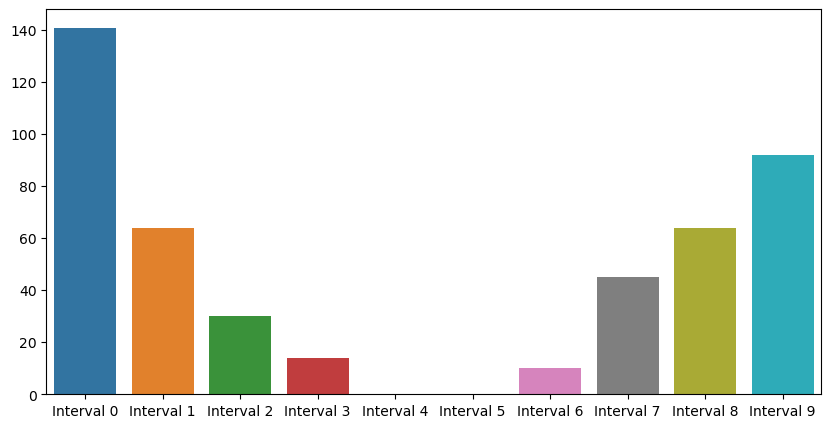

Signal appeared 141 Times in interval 0
Row 2155: Not enough future rows for average calculation


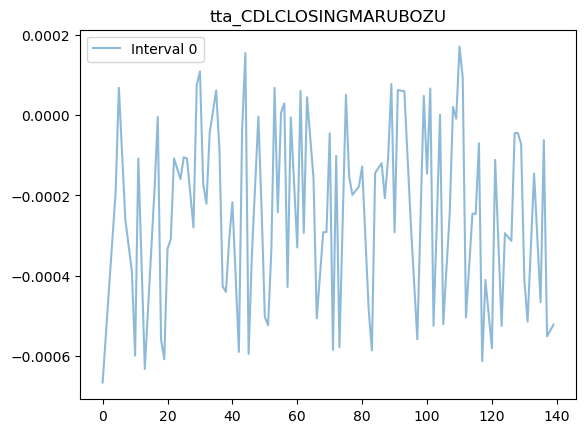

Signal appeared 249 Times in total.


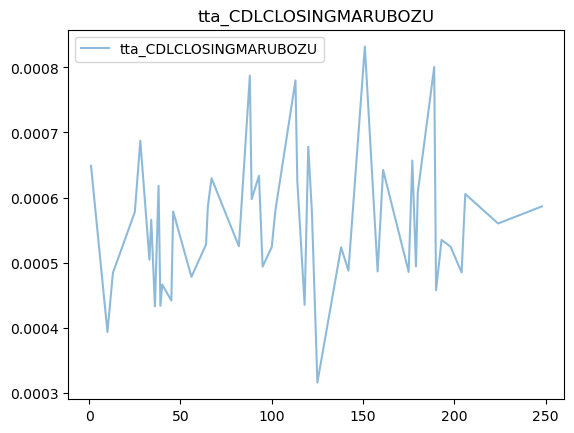

In [ ]:
feature = 'tta_CDLCLOSINGMARUBOZU'
see_interval(df_sorted,[0,5,9], feature)
count_interval(df_sorted,np.arange(10),feature, [-100,100])
categorical_pred_distribution(df_sorted,[0],feature,[-100,100],5)
categorical_pred_FULL(df_sorted,feature, [-100], 1)